# Stable Diffusion Identity Evaluation (ArcFace)
This notebook evaluates how well different Stable Diffusion fine‑tuning methods preserve the identity of a person, using **InsightFace + ArcFace (`buffalo_l`)** embeddings.

In [1]:
!git clone https://github.com/huyhuunguyen1705/AI_Avatar_Project.git

Cloning into 'AI_Avatar_Project'...
remote: Enumerating objects: 167, done.
remote: Total 167 (delta 0), reused 0 (delta 0), pack-reused 167 (from 3)
Receiving objects: 100% (167/167), 124.00 MiB | 17.49 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [2]:
!pip install -q insightface opencv-python numpy tqdm matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 23.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 69.5 MB/s eta 0:00:00


## 1. Initialize `FaceAnalysis` with ArcFace (`buffalo_l`)

In [4]:
!pip install -U insightface onnxruntime-gpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.2/283.2 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.4 MB/s eta 0:00:00


In [5]:
from insightface.app import FaceAnalysis

# Try GPU first; fall back to CPU if not available
app = FaceAnalysis(name='buffalo_l', providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:05<00:00, 52709.34KB/s]


Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with o

## 2. Helper to extract a normalized embedding from an image

In [6]:
import cv2
import numpy as np

def get_embedding(path: str) -> np.ndarray:
    """Return L2‑normalized ArcFace embedding for the first detected face."""
    img = cv2.imread(path)
    faces = app.get(img)
    if len(faces) == 0:
        raise ValueError(f"No face detected in {path}")
    emb = faces[0].embedding
    return emb / np.linalg.norm(emb)

## 3. Build identity template from the training images

In [7]:
import glob, tqdm

train_paths = sorted(glob.glob('/content/AI_Avatar_Project/Dataset/Itay/*.jpg'))  # adjust if your path differs
print(f'Found {len(train_paths)} training images.')

E_train = [get_embedding(p) for p in tqdm.tqdm(train_paths)]
T = np.mean(E_train, axis=0)
T /= np.linalg.norm(T)  # final normalization
print('Template created. Shape:', T.shape)

Found 20 training images.


100%|██████████| 20/20 [00:02<00:00,  7.21it/s]

Template created. Shape: (512,)


## 4. Compute cosine similarities for generated images

In [16]:
from collections import defaultdict

methods = {
    # ───────── Stable-Diffusion 1.5 ─────────
    'SD15_Dreambooth'       : '/content/AI_Avatar_Project/Generated/SD1.5/Dreambooth/Itay/*.png',
    'SD15_LoRA'             : '/content/AI_Avatar_Project/Generated/SD1.5/LoRA/Itay/*.png',
    'SD15_TextualInversion' : '/content/AI_Avatar_Project/Generated/SD1.5/Textual_Inversion/Itay/*.png',

    # ───────── Stable-Diffusion XL ──────────
    'SDXL_Dreambooth'       : '/content/AI_Avatar_Project/Generated/SDXL/Dreambooth/Itay/*.png',
    'SDXL_LoRA'             : '/content/AI_Avatar_Project/Generated/SDXL/LoRA/Itay/*.png',
    'SDXL_TextualInversion' : '/content/AI_Avatar_Project/Generated/SDXL/Textual_Inversion/Itay/*.png',

    # ───────── Others ────────────
    'InstantID_Hires'       : '/content/AI_Avatar_Project/Generated/InstantID_Hires.fix/*.png',
    'Kohya_LoRA'            : '/content/AI_Avatar_Project/Generated/Kohya_LoRA/Itay/*.png',
}


scores = defaultdict(list)
import numpy as np, glob, tqdm

for m, patt in methods.items():
    gen_paths = sorted(glob.glob(patt))
    if len(gen_paths) == 0:
        print(f'Warning: no images found for {m} with pattern {patt}')
    for p in tqdm.tqdm(gen_paths, desc=m):
        g = get_embedding(p)
        if g is None:
            print(f'No face detected in {p}, similarity set to 0')
            scores[m].append(0.0)
        else:
            s = float(np.dot(T, g))  # cosine similarity
            scores[m].append(s)

print('Done computing similarities.')

Kohya_LoRA: 100%|██████████| 3/3 [00:00<00:00, 20.52it/s]

Done computing similarities.


## 5. Summarize and rank the methods

In [31]:
import numpy as np, pandas as pd

summary = {m: np.mean(v) for m, v in scores.items() if v}
ranked = sorted(summary.items(), key=lambda x: -x[1])

print('Average cosine similarity per method:')
for m, s in summary.items():
    print(f'{m:20s}: {s:.4f}')

print('\nRanking (higher is better):')
for idx, (m, s) in enumerate(ranked, 1):
    print(f'{idx}. {m}  ({s:.4f})')

# Save detailed scores if needed
pd.DataFrame(dict((m, v) for m, v in scores.items())).to_csv('similarity_scores.csv', index=False)

Average cosine similarity per method:
SD15_Dreambooth     : 0.2970
SD15_LoRA           : 0.5746
SD15_TextualInversion: 0.1735
SDXL_Dreambooth     : 0.3415
SDXL_LoRA           : 0.5480
SDXL_TextualInversion: 0.1912
InstantID_Hires     : 0.6705
Kohya_LoRA          : 0.2530

Ranking (higher is better):
1. InstantID_Hires  (0.6705)
2. SD15_LoRA  (0.5746)
3. SDXL_LoRA  (0.5480)
4. SDXL_Dreambooth  (0.3415)
5. SD15_Dreambooth  (0.2970)
6. Kohya_LoRA  (0.2530)
7. SDXL_TextualInversion  (0.1912)
8. SD15_TextualInversion  (0.1735)


In [34]:
import numpy as np, pandas as pd

summary  = {m: np.mean(v) for m, v in scores.items() if v}

df_avg = (pd.Series(summary, name='Average cosine')
            .round(4)
            .sort_values(ascending=False)
            .to_frame())

display(df_avg)

df_avg.to_csv('average_similarity_per_method.csv')

print('Ranking (higher is better):')
for idx, (m, s) in enumerate(df_avg['Average cosine'].items(), 1):
    print(f'{idx}. {m:20s}: {s:.4f}')


,Average cosine
InstantID_Hires,0.6705
SD15_LoRA,0.5746
SDXL_LoRA,0.5480
SDXL_Dreambooth,0.3415
SD15_Dreambooth,0.2970
Kohya_LoRA,0.2530
SDXL_TextualInversion,0.1912
SD15_TextualInversion,0.1735


Ranking (higher is better):
1. InstantID_Hires     : 0.6705
2. SD15_LoRA           : 0.5746
3. SDXL_LoRA           : 0.5480
4. SDXL_Dreambooth     : 0.3415
5. SD15_Dreambooth     : 0.2970
6. Kohya_LoRA          : 0.2530
7. SDXL_TextualInversion: 0.1912
8. SD15_TextualInversion: 0.1735


## 6. (Optional) Visualize distributions

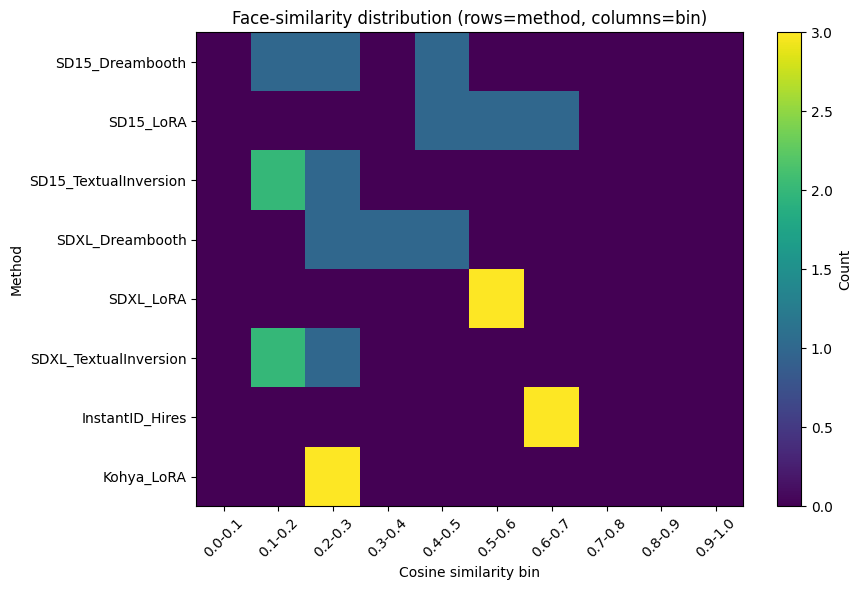

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

bins = np.linspace(0, 1, 11)
bin_labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}"
              for i in range(len(bins)-1)]

matrix = {m: np.histogram(vals, bins=bins)[0]
          for m, vals in scores.items() if vals}

df = pd.DataFrame(matrix, index=bin_labels).T

# ----- 2. Heatmap -----
plt.figure(figsize=(len(bin_labels)*0.9, len(df)*0.5 + 2))
plt.imshow(df.values, aspect='auto')
plt.colorbar(label='Count')
plt.xticks(ticks=np.arange(len(bin_labels)),
           labels=bin_labels, rotation=45)
plt.yticks(ticks=np.arange(len(df.index)),
           labels=df.index)
plt.xlabel('Cosine similarity bin')
plt.ylabel('Method')
plt.title('Face-similarity distribution (rows=method, columns=bin)')
plt.tight_layout()
plt.show()
